<a href="https://colab.research.google.com/github/imroytran/Homework-DLS/blob/master/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%A1%D0%B8%D0%BC%D0%BF%D1%81%D0%BE%D0%BD%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Pytorch
from torchvision import transforms, models, datasets
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, Dataset, WeightedRandomSampler
import torch.nn as nn
import pickle
from torch.optim import lr_scheduler

import random
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

from tqdm import tqdm, tqdm_notebook

# Data science tools
import numpy as np
import pandas as pd
import os
from sklearn.model_selection  import train_test_split

# Image Manipolations
from PIL import Image
import PIL

from pathlib import Path

from sklearn.preprocessing import LabelEncoder

# Visualizations

from matplotlib import colors, pyplot as plt
%matplotlib inline

import copy

#Load data from Google Drive#

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!unzip -q /content/gdrive/My\ Drive/simpsons/simpsons_dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/simpsons/testset.zip -d test

replace train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace test/testset/testset/img0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Data Exploration#

In [0]:
traindir = 'train/simpsons_dataset'
testdir = 'test/testset'


In [109]:
classes = []
n_train = []


classes =  os.listdir(traindir)

for i in classes:
    images = os.listdir(traindir+'/'+i)
    n_train.append(len(images))

p_ntrain = []
for n in n_train:
  p_ntrain.append(n/sum(np.array(n_train)))
classes_df = pd.DataFrame({'Classes':classes, 'n_train':n_train, 'p_ntrain':p_ntrain}).sort_values('Classes')

n_classes = len(classes) 
classes_df.head()


,Classes,n_train,p_ntrain
21,abraham_grampa_simpson,913,0.043615
34,agnes_skinner,42,0.002006
16,apu_nahasapeemapetilon,623,0.029762
13,barney_gumble,106,0.005064
15,bart_simpson,1342,0.064109


**Distribution of Images**

Text(0.5, 1.0, 'Training images by classes')

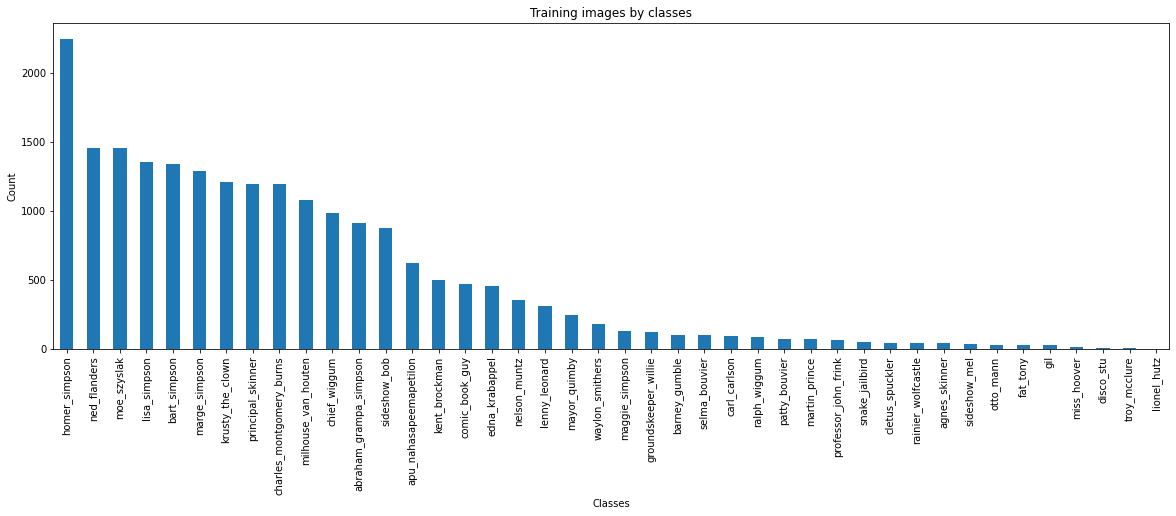

In [6]:
classes_df.sort_values('n_train', ascending=False).set_index('Classes')['n_train'].plot.bar(figsize=(20,6))
plt.ylabel('Count')
plt.title('Training images by classes')

#Data Iterators#

In [0]:
train_val_files = sorted(list(Path(traindir).rglob('*.jpg')))
test_files = sorted(list(Path(testdir).rglob('*jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

In [0]:
# Routines dataset
DATA_MODES = ['train', 'val', 'test']
# Standart size images ImageNet
RESCALE_SIZE = 224
# Working mode on GPU
DEVICE = torch.device("cuda")

batch_size = 64


**Data Oversamping**

In [0]:
simpsons_path = {}
for label in np.unique(train_val_labels).tolist():
  simpsons_path[label] = []

for path, label in zip(train_val_files, train_val_labels):
  simpsons_path[label].append(path)

In [0]:
for obj in simpsons_path:
  if len(simpsons_path[obj]) < 100:
    simpsons_path[obj] = simpsons_path[obj]*(100//len(simpsons_path[obj]))
    simpsons_path[obj].extend(simpsons_path[obj][:100-len(simpsons_path[obj])])

In [0]:
new_train_val_files = []

for obj in simpsons_path:
  new_train_val_files.extend(simpsons_path[obj])

new_train_val_labels = [path.parent.name for path in new_train_val_files]


In [12]:
class_count = np.unique(train_val_labels, return_counts=True)
new_class_count = np.unique(new_train_val_labels, return_counts=True)[1]
print(class_count[1])
print(new_class_count)

[ 913   42  623  106 1342   98 1193  986   47  469    8  457   27   27
  121 2246  498 1206  310    3 1354  128 1291   71  246 1079   17 1452
 1454  358   32   72 1194   65   45   89  103  877   40   55    8  181]
[ 913  100  623  106 1342  100 1193  986  100  469  100  457  100  100
  121 2246  498 1206  310  100 1354  128 1291  100  246 1079  100 1452
 1454  358  100  100 1194  100  100  100  103  877  100  100  100  181]


**Class data mode**

In [0]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform_train_val = transforms.Compose([
                      transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomRotation(15),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225]) # ImageNet standarts
                  ])
        transform = transforms.Compose([
                    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
                   ])
        x = self.load_sample(self.files[index])
        if self.mode == 'test':
            return transform(x)
        else:
          x = transform_train_val(x)
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y


Text(0.5, 1.0, 'Training images by new classes')

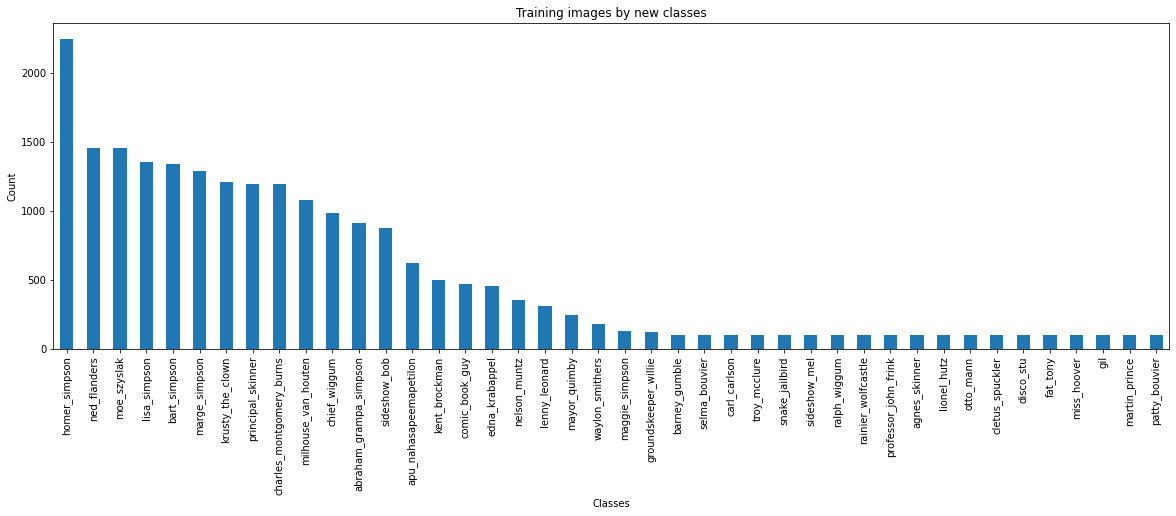

In [14]:
Classes = []
n_train = []
for key, values in simpsons_path.items():
  Classes.append(key)
  n_train.append(len(values))
Classes_df = pd.DataFrame({'Classes':Classes, 'n_train': n_train}).sort_values('Classes')
Classes_df.sort_values('n_train', ascending=False).set_index('Classes')['n_train'].plot.bar(figsize=(20,6))
plt.ylabel('Count')
plt.title('Training images by new classes')

**DataLoader**

In [0]:
# Datasets
train_files, val_files = train_test_split(new_train_val_files, test_size=0.25, stratify= new_train_val_labels)

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

# DataLoader interator
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


**Visualization samples**

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

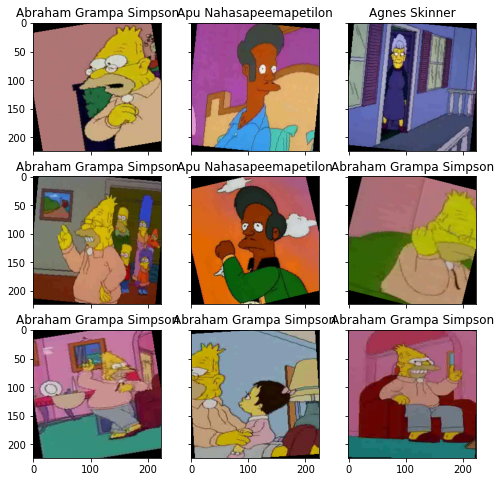

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

#Training#

**Train on GPU**

In [0]:
DEVICE = torch.device('cuda')

**Model**

In [0]:
model = models.resnet50(pretrained=True)


In [0]:
n_inputs = model.fc.in_features

model.fc = nn.Sequential(nn.Linear(n_inputs, 1024),
                                 nn.BatchNorm1d(1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 1024),
                                 nn.BatchNorm1d(1024),
                                 nn.ReLU(),
                                 nn.Dropout(p =0.4),
                                 nn.Linear(1024, n_classes))

In [0]:
best_model_wts = copy.deepcopy(model.state_dict())

In [0]:
torch.cuda.empty_cache()

**Functions to training**

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer, exp_lr_scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    exp_lr_scheduler.step()         
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    best_acc = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())
    return val_loss, val_acc

In [0]:
def train(train_loader, val_loader, model, epochs, batch_size):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        val_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        epochs (int): maximum number of training epochs

    Returns
    --------
        history (DataFrame): history of train and validation loss and accuracy
    """
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, exp_lr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

**Move model to GPU**

In [0]:
model = model.to(DEVICE)

In [28]:
history = train(train_loader, val_loader, model=model, epochs=20, batch_size=batch_size)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.0661389855288383


epoch:   5%|▌         | 1/20 [04:56<1:33:49, 296.28s/it]


Epoch 001 train_loss: 1.0661     val_loss 0.3417 train_acc 0.7593 val_acc 0.9253
loss 0.3632464155877032


epoch:  10%|█         | 2/20 [09:42<1:28:00, 293.34s/it]


Epoch 002 train_loss: 0.3632     val_loss 0.2207 train_acc 0.9047 val_acc 0.9444
loss 0.1942251722296309


epoch:  15%|█▌        | 3/20 [14:26<1:22:18, 290.49s/it]


Epoch 003 train_loss: 0.1942     val_loss 0.2082 train_acc 0.9496 val_acc 0.9450
loss 0.13460622912512804


epoch:  20%|██        | 4/20 [19:07<1:16:41, 287.58s/it]


Epoch 004 train_loss: 0.1346     val_loss 0.1451 train_acc 0.9653 val_acc 0.9647
loss 0.11234324807000462


epoch:  25%|██▌       | 5/20 [23:48<1:11:24, 285.64s/it]


Epoch 005 train_loss: 0.1123     val_loss 0.1906 train_acc 0.9709 val_acc 0.9552
loss 0.09086240716653012


epoch:  30%|███       | 6/20 [28:29<1:06:20, 284.32s/it]


Epoch 006 train_loss: 0.0909     val_loss 0.2832 train_acc 0.9764 val_acc 0.9315
loss 0.08408721681415326


epoch:  35%|███▌      | 7/20 [33:10<1:01:21, 283.19s/it]


Epoch 007 train_loss: 0.0841     val_loss 0.1685 train_acc 0.9776 val_acc 0.9605
loss 0.0358218745708334


epoch:  40%|████      | 8/20 [37:49<56:24, 282.08s/it]


Epoch 008 train_loss: 0.0358     val_loss 0.0814 train_acc 0.9915 val_acc 0.9804
loss 0.021725000552213238


epoch:  45%|████▌     | 9/20 [42:29<51:33, 281.26s/it]


Epoch 009 train_loss: 0.0217     val_loss 0.0789 train_acc 0.9948 val_acc 0.9830
loss 0.016953326041344696


epoch:  50%|█████     | 10/20 [47:09<46:48, 280.84s/it]


Epoch 010 train_loss: 0.0170     val_loss 0.0826 train_acc 0.9963 val_acc 0.9803
loss 0.015369105535123056


epoch:  55%|█████▌    | 11/20 [51:53<42:17, 281.89s/it]


Epoch 011 train_loss: 0.0154     val_loss 0.0774 train_acc 0.9968 val_acc 0.9830
loss 0.013480666034692968


epoch:  60%|██████    | 12/20 [56:37<37:39, 282.49s/it]


Epoch 012 train_loss: 0.0135     val_loss 0.0813 train_acc 0.9971 val_acc 0.9825
loss 0.011796301674148697


epoch:  65%|██████▌   | 13/20 [1:01:17<32:51, 281.71s/it]


Epoch 013 train_loss: 0.0118     val_loss 0.0834 train_acc 0.9973 val_acc 0.9815
loss 0.011342232881106511


epoch:  70%|███████   | 14/20 [1:05:57<28:07, 281.18s/it]


Epoch 014 train_loss: 0.0113     val_loss 0.0823 train_acc 0.9974 val_acc 0.9830
loss 0.009349989418908864


epoch:  75%|███████▌  | 15/20 [1:10:36<23:23, 280.71s/it]


Epoch 015 train_loss: 0.0093     val_loss 0.0822 train_acc 0.9981 val_acc 0.9808
loss 0.009932085598455563


epoch:  80%|████████  | 16/20 [1:15:16<18:41, 280.33s/it]


Epoch 016 train_loss: 0.0099     val_loss 0.0808 train_acc 0.9978 val_acc 0.9814
loss 0.010177174770703611


epoch:  85%|████████▌ | 17/20 [1:19:55<14:00, 280.10s/it]


Epoch 017 train_loss: 0.0102     val_loss 0.0789 train_acc 0.9981 val_acc 0.9832
loss 0.009936621114263407


epoch:  90%|█████████ | 18/20 [1:24:34<09:19, 279.85s/it]


Epoch 018 train_loss: 0.0099     val_loss 0.0807 train_acc 0.9977 val_acc 0.9825
loss 0.009408479476216505


epoch:  95%|█████████▌| 19/20 [1:29:13<04:39, 279.57s/it]


Epoch 019 train_loss: 0.0094     val_loss 0.0835 train_acc 0.9981 val_acc 0.9815
loss 0.008877974535737718


epoch: 100%|██████████| 20/20 [1:33:52<00:00, 281.63s/it]


Epoch 020 train_loss: 0.0089     val_loss 0.0836 train_acc 0.9984 val_acc 0.9821


In [0]:
loss, acc, val_loss, val_acc = zip(*history)

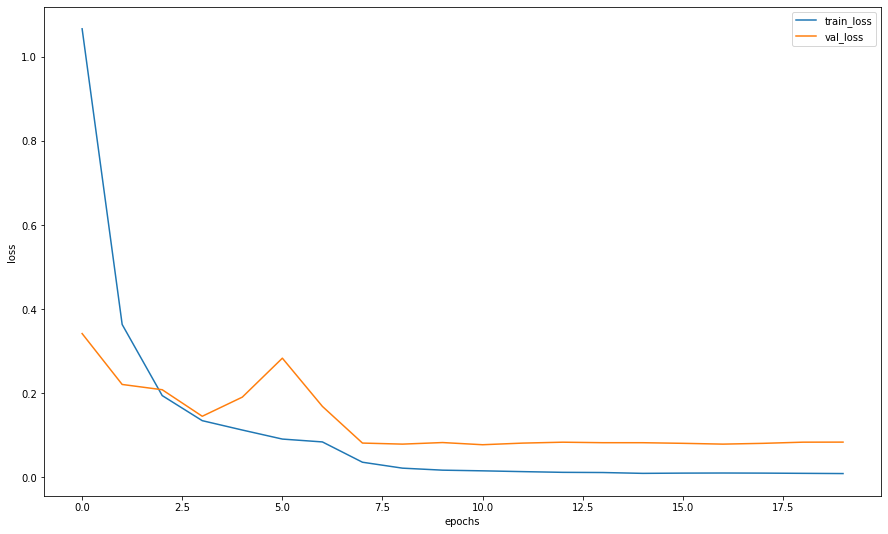

In [30]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
 torch.save(best_model_wts, "gdrive/My Drive/simpsons/model_weights.pth")

#Sample#

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [108]:
model.load_state_dict(torch.load('gdrive/My Drive/simpsons/model_weights.pth'))

<All keys matched successfully>

In [0]:

random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [0]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)


actual_labels = np.array([val_dataset[id][1] for id in idxs])

preds_class = [label_encoder.classes_[i] for i in y_pred]

preds_class = np.array(list(label_encoder.transform(preds_class)))


In [105]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='weighted')

1.0

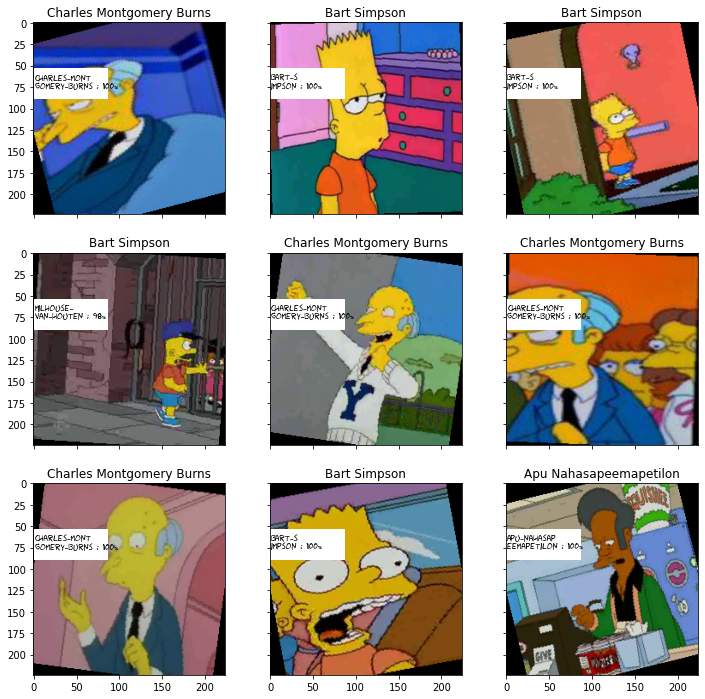

In [37]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

#Submit на Kaggle#

In [0]:
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [40]:
import pandas as pd

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)